In [135]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.rcParams['figure.figsize'] = [10, 8]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
!ls ../Databases

reviewsV1db  reviewsV1.db  reviewsV2.db  reviewsV3.db


## 1. Loading the dataset

In [3]:
with sqlite3.connect('../Databases/reviewsV1.db') as conn:
    data = pd.read_sql_query('SELECT * FROM Review', conn)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Polarity
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,good stew smells bought looks vitality appreci...,positive
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,small product peanuts arrived labeled jumbo si...,negative
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",treat liberally citrus brother nuts highly cas...,positive
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,secret ingredient flavor root cherry looking o...,negative
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,taffy wide delivery assortment great yummy,positive


In [5]:
data.sort_values(by='Time', inplace=True)
data.reset_index(drop=True, inplace=True)
TRAIN_SIZE = int(data.shape[0] * 0.7)
TEST_SIZE = data.shape[0] - TRAIN_SIZE

In [6]:
TRAIN_SIZE

254883

In [7]:
TEST_SIZE

109236

In [8]:
data_train = data[0: TRAIN_SIZE]
data_test = data[TRAIN_SIZE:]

In [9]:
assert(data_train.shape[0] == TRAIN_SIZE)
assert(data_test.shape[0] == TEST_SIZE)
assert(data.Time.max() == data_test.Time.reset_index(drop=True)[TEST_SIZE -1])
assert(data.Time.min() == data_train.Time.reset_index(drop=True)[0])

## 2. Featurization

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
cunt = CountVectorizer(max_features=3000)
cunt.fit(data_train.Text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [76]:
Dtrain = cunt.transform(data_train.Text)
Dtrain.get_shape()

(254883, 3000)

In [12]:
Dtest = cunt.transform(data_test.Text)
Dtest.get_shape()

(109236, 3000)

## 3. Scaling the data

In [13]:
from sklearn.preprocessing import StandardScaler

In [16]:
Dtrain = Dtrain.toarray() # Almost 11 GB of RAM

In [14]:
sclr = StandardScaler(copy=True)

In [18]:
Dtrain_scaled = sclr.fit_transform(Dtrain)  # CAUTION: 2x RAM Usage, copy = False seems broken

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
del Dtrain ## Free up some RAM

In [15]:
Dtest = Dtest.toarray()

In [16]:
Dtest_scaled = sclr.fit_transform(Dtest)  # CAUTION: 2x RAM Usage, copy = False seems broken

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
del Dtest ## Free up some RAM

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [24]:
params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}

In [25]:
estimator = LogisticRegression(random_state=42)

In [26]:
print(estimator)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [27]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=10,
                    return_train_score=True,
                    verbose=2)

In [28]:
features = Dtrain_scaled
labels = data_train.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [29]:
features.shape

(254883, 3000)

In [30]:
len(labels)

254883

In [31]:
grid.fit(features, labels)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.5min
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.5min
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.4min
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.5min
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.4min
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.5min
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total= 1.5min
[CV] C

[CV] ........................................... C=10.0, total= 3.4min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 3.2min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 3.2min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 3.2min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 3.2min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 3.2min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 3.5min
[CV] C=100.0 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 273.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'recall', 'f1', 'accuracy', 'precision'}, verbose=2)

In [35]:
from collections import defaultdict

In [36]:
def get_summary(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [37]:
get_summary(grid)

,Iter #,train_recall,test_recall,train_f1,test_f1,train_accuracy,test_accuracy,train_precision,test_precision,fit_time,score_time,C
0,1,0.976441,0.972968,0.946823,0.944122,0.906684,0.902006,0.918949,0.916985,87.309455,0.393950,0.0001
1,2,0.976319,0.973055,0.950039,0.946812,0.912636,0.906981,0.925138,0.921988,129.000631,0.403928,0.0010
2,3,0.974651,0.970842,0.950819,0.947103,0.914216,0.907730,0.928124,0.924535,186.766967,0.546892,0.0100
3,4,0.974341,0.970519,0.950913,0.947133,0.914417,0.907817,0.928586,0.924885,197.997197,0.532091,0.1000
4,5,0.974301,0.970492,0.950921,0.947147,0.914434,0.907844,0.928636,0.924937,200.108753,0.537229,1.0000
5,6,0.974299,0.970492,0.950924,0.947149,0.914440,0.907848,0.928644,0.924941,199.290516,0.578361,10.0000
6,7,0.974299,0.970487,0.950924,0.947146,0.914440,0.907844,0.928644,0.924940,198.965694,0.571653,100.0000
7,8,0.974299,0.970487,0.950924,0.947146,0.914440,0.907844,0.928644,0.924940,200.596844,0.579638,1000.0000
8,9,0.974299,0.970487,0.950924,0.947146,0.914440,0.907844,0.928644,0.924940,200.238887,0.587246,10000.0000


In [32]:
grid.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 4. Saving the best estimator

In [172]:
from sklearn.externals import joblib

In [48]:
joblib.dump(grid.best_estimator_, 'best.model')

['best.model']

## 5. Loading the best estimator

In [203]:
clf = joblib.load('best.model')

In [174]:
clf.coef_

array([[-0.00953235, -0.00435521,  0.04769258, ...,  0.11586617,
        -0.04707746,  0.02314036]])

In [26]:
xTrain = Dtest_scaled
actuals = data_test.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [27]:
xTrain

array([[-0.02477352, -0.03556568, -0.16925037, ..., -0.09480176,
        -0.06835356, -0.03384704],
       [-0.02477352, -0.03556568, -0.16925037, ..., -0.09480176,
        -0.06835356, -0.03384704],
       [-0.02477352, -0.03556568, -0.16925037, ..., -0.09480176,
        -0.06835356, -0.03384704],
       ...,
       [-0.02477352, -0.03556568, -0.16925037, ..., -0.09480176,
        -0.06835356, -0.03384704],
       [-0.02477352, -0.03556568, -0.16925037, ..., -0.09480176,
        -0.06835356, -0.03384704],
       [-0.02477352, -0.03556568, -0.16925037, ..., -0.09480176,
        -0.06835356, -0.03384704]])

In [28]:
actuals

array([1, 1, 1, ..., 0, 0, 1])

In [29]:
preds = clf.predict(xTrain)

## 6. Reporting Evaluation metrics for best estimator accoring to F1 score

In [30]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [54]:
acs = accuracy_score(actuals, preds)
pre = precision_score(actuals, preds)
rec = recall_score(actuals, preds)
f1 = f1_score(actuals, preds)

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
x.add_row([acs, pre, rec, f1])

print(x)

+--------------------+--------------------+--------------------+--------------------+
|   test_accuracy    |   test_precision   |    test_recall     |      test_f1       |
+--------------------+--------------------+--------------------+--------------------+
| 0.8963253872349775 | 0.9077152225405725 | 0.9733473824312333 | 0.9393863165613174 |
+--------------------+--------------------+--------------------+--------------------+


## 7. Feature Importance

In [219]:
def get_top_n_features(n, weights, typ='+'):
    if typ == '+':
        INDEX_topW = weights.argsort()[::-1][0:n]
    elif typ == '-':
        INDEX_topW = weights.argsort()[0:n]
    topW = weights[INDEX_topW]
    featureNames = np.array(cunt.get_feature_names())
    return pd.DataFrame({'features': featureNames[INDEX_topW],
 'score': topW})

In [221]:
Wmod = np.abs(clf.coef_).ravel()
fimp = get_top_n_features(n=20, weights=Wmod)

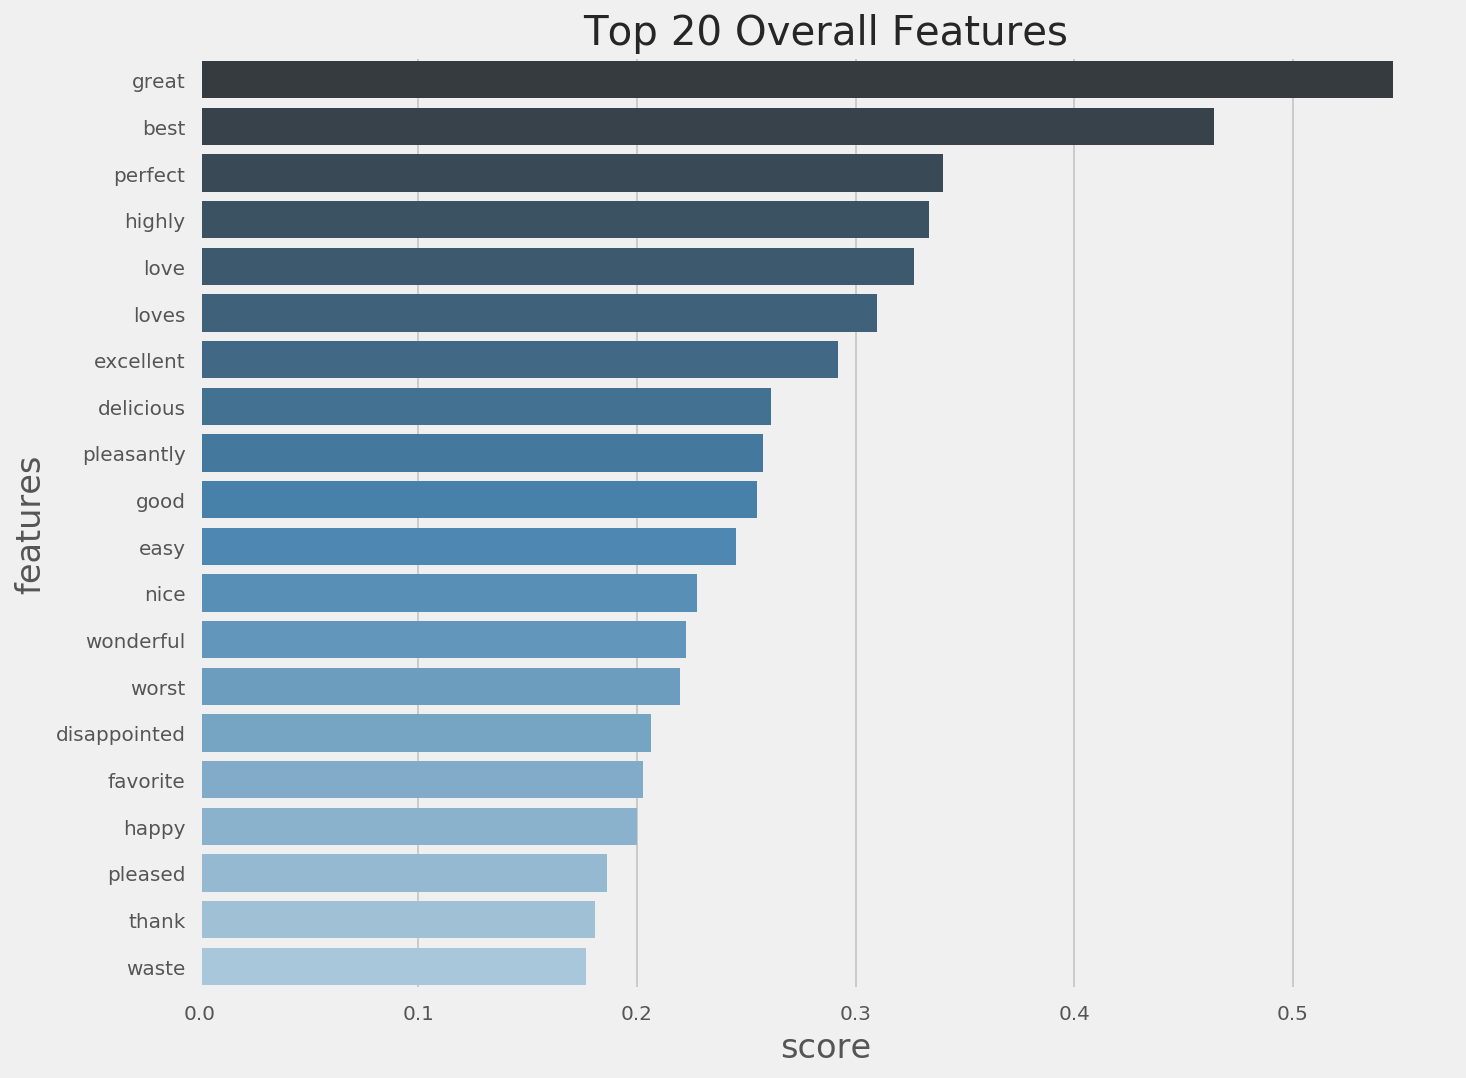

In [222]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Blues_d');
plt.title('Top 20 Overall Features');

In [236]:
W = clf.coef_.ravel()

In [237]:
fimp = get_top_n_features(n=20, weights=W, typ='-')

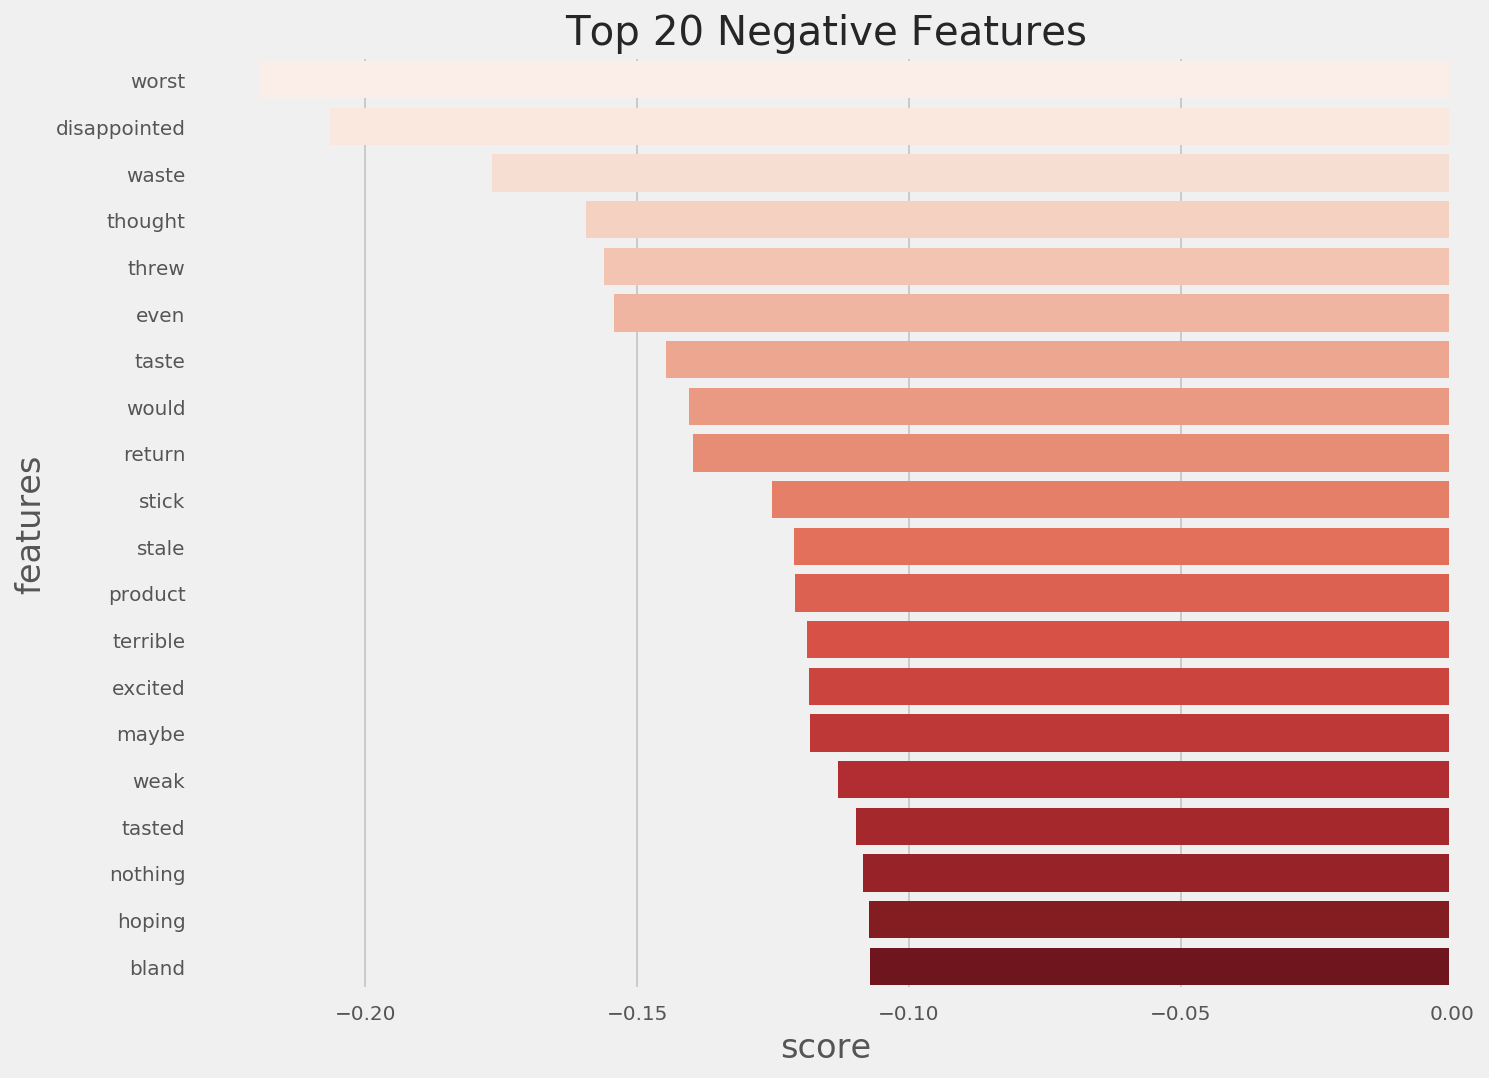

In [238]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Reds');
plt.title('Top 20 Negative Features');

In [230]:
fimp = get_top_n_features(n=20, weights=W, typ='+')

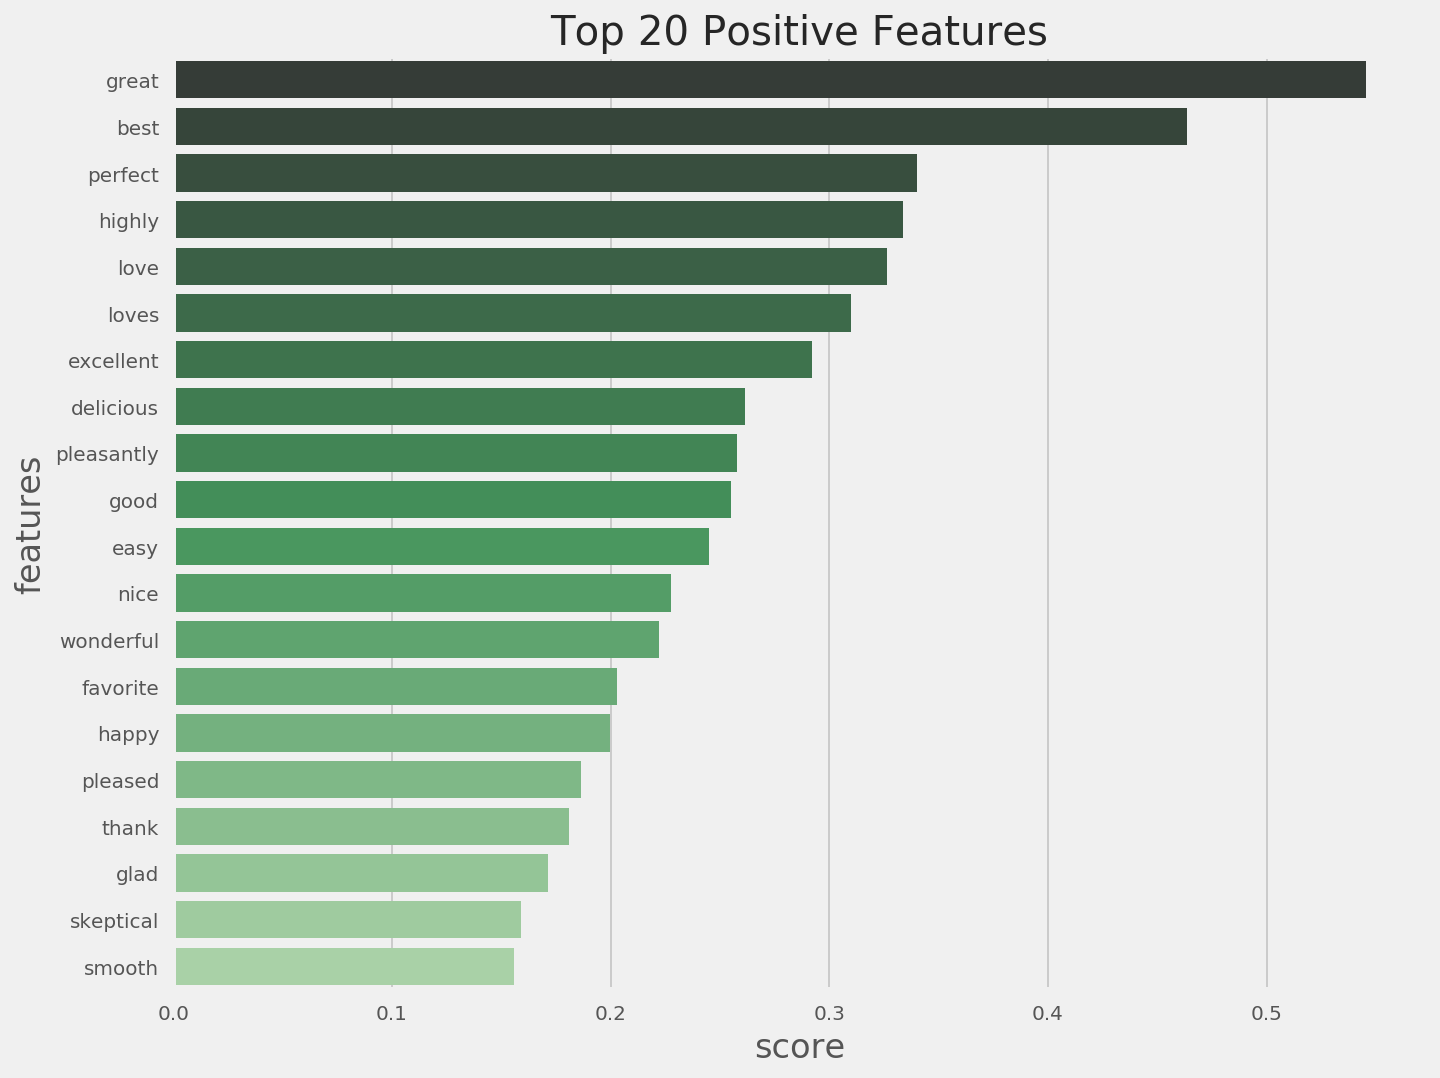

In [233]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Greens_d');
plt.title('Top 20 Positive Features');

## 8. Multi-colinearity & Pertubation